In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
pip install transformers

     |████████████████████████████████| 368kB 2.7MB/s 
     |████████████████████████████████| 1.0MB 68.4MB/s 
     |████████████████████████████████| 860kB 47.1MB/s 
     |████████████████████████████████| 645kB 44.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=ee266b896c9dd71195ad91603017be2317ad68525a899b5b28b21865606d3f95
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertConfig
from transformers import AdamW, DistilBertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [0]:
# Upload the train file from your local drive
# from google.colab import files
# uploaded = files.upload()

Saving data.csv to data.csv


In [5]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive/
/gdrive


In [0]:
# data = pd.read_csv('data.csv')
data = pd.read_csv('My Drive/Colab Notebooks/data.csv')

In [7]:
df = data[['Rating','Review_text']].rename(columns={'Rating': 'label', 'Review_text': 'sentence'})
df.label = df.label.astype(int)
df.label = df.label - 1
df = df.dropna()

# df = df.head(1000)
df.sample(10)

,label,sentence
60437,4,Originality confirm by APPLE Most reliable ele...
16015,4,"jio tv,netflix not supported.kindly improve in..."
28787,0,Performance is not good as configuration
48506,4,"Front camera is awesome, realme gives you a pr..."
32508,0,"Performance Very worst,Touch is not working an..."
26344,4,It's perfect
55160,0,1. Battery life is not as good as 6000 mah. It...
20439,4,Excellent Finishing...Fast Charging...weightle...
22740,3,First of all for all of those who will take my...
27570,4,Wonderful .. I love it


## Hyperparameters values as below
1. MAX_LEN = 128
2. learning_rate = 2e-5
3. batch_size = 32
4. epochs = 2

##### Select a batch size for training. For fine-tuning on a specific task, recommend batch size is 16 or 32
##### Number of training epochs (recommend between 2 and 4)

In [0]:
MAX_LEN = 128
learning_rate = 2e-5
batch_size = 32
epochs = 2

In [9]:
# Create sentence and label lists
sentences_actual = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences_actual = ["[CLS] " + sentences_actual + " [SEP]" for sentences_actual in sentences_actual]
labels_actual = df.label.values

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences_actual]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

index = []
for i,x in enumerate(tokenized_texts):
    if len(x)<MAX_LEN:
        index.append(i)
sentences = []
labels=[]
for i in index:
   sentences.append(sentences_actual[i]) 
   labels.append(labels_actual[i])
print('total sentences are:',len(sentences))

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=learning_rate,
                     )


# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

100%|██████████| 231508/231508 [00:00<00:00, 425656.91B/s]


Tokenize the first sentence:
['[CLS]', 'i', 'liked', 'it', '[SEP]']
total sentences are: 58322
Tokenize the first sentence:
['[CLS]', 'i', 'liked', 'it', '[SEP]']


100%|██████████| 267967963/267967963 [00:24<00:00, 10962329.94B/s]


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.8464226722717285


Epoch:  50%|█████     | 1/2 [18:42<18:42, 1122.59s/it]

Validation Accuracy: 0.684672890103218
Train loss: 0.7657676339149475


Epoch: 100%|██████████| 2/2 [37:22<00:00, 1121.64s/it]

Validation Accuracy: 0.6843313600485732


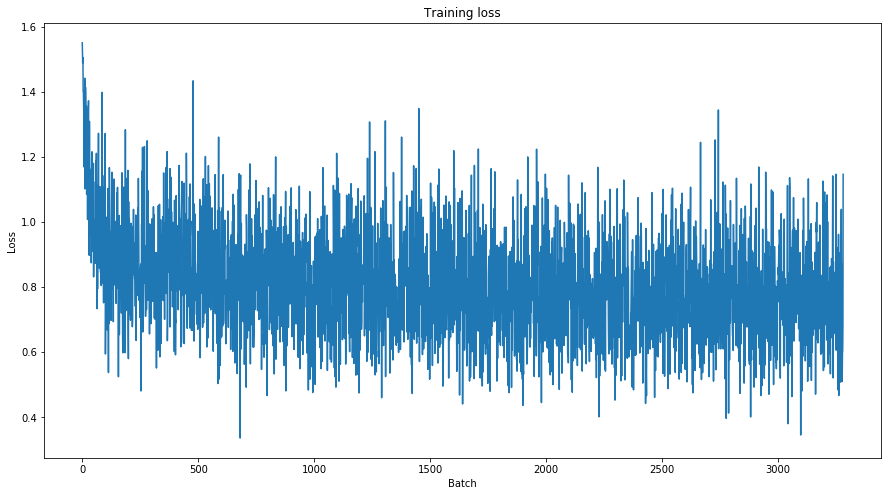

In [10]:
# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids,  attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0])    
    # # Backward pass
    loss[0].backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss[0]
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids,  attention_mask=b_input_mask)[0]
     
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## Hyperparameters values as below
1. MAX_LEN = 128
2. learning_rate = 2e-5
3. batch_size = 16
4. epochs = 3

In [0]:
MAX_LEN = 128
learning_rate = 2e-5
batch_size = 16
epochs = 3


In [9]:
# Create sentence and label lists
sentences_actual = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences_actual = ["[CLS] " + sentences_actual + " [SEP]" for sentences_actual in sentences_actual]
labels_actual = df.label.values

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences_actual]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

index = []
for i,x in enumerate(tokenized_texts):
    if len(x)<MAX_LEN:
        index.append(i)
sentences = []
labels=[]
for i in index:
   sentences.append(sentences_actual[i]) 
   labels.append(labels_actual[i])
print('total sentences are:',len(sentences))

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=learning_rate,
                     )


# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

100%|██████████| 231508/231508 [00:00<00:00, 433388.78B/s]


Tokenize the first sentence:
['[CLS]', 'i', 'liked', 'it', '[SEP]']
total sentences are: 58322
Tokenize the first sentence:
['[CLS]', 'i', 'liked', 'it', '[SEP]']


100%|██████████| 267967963/267967963 [00:23<00:00, 11508185.85B/s]


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.8430401682853699


Epoch:  33%|███▎      | 1/3 [06:28<12:57, 388.65s/it]

Validation Accuracy: 0.6886035007610349
Train loss: 0.7635254859924316


Epoch:  67%|██████▋   | 2/3 [12:57<06:28, 388.57s/it]

Validation Accuracy: 0.6875380517503805
Train loss: 0.6919463872909546


Epoch: 100%|██████████| 3/3 [19:25<00:00, 388.58s/it]

Validation Accuracy: 0.6884322678843227


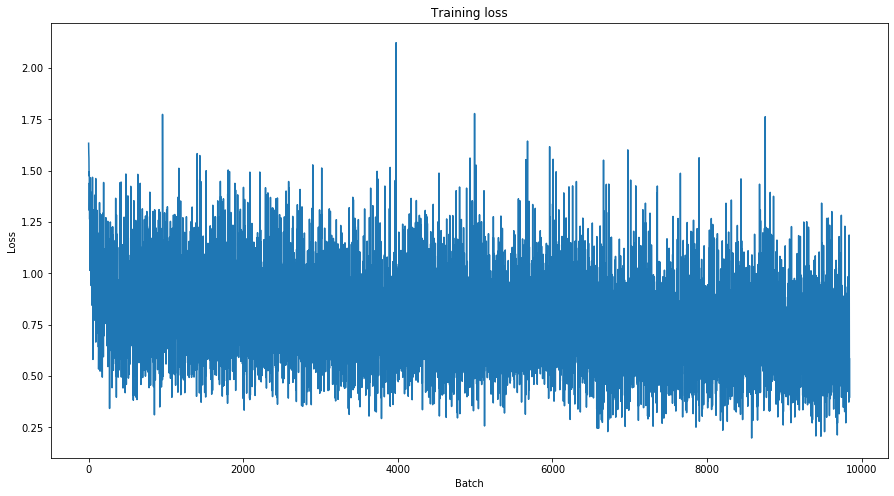

In [10]:
# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids,  attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0])    
    # # Backward pass
    loss[0].backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss[0]
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, attention_mask=b_input_mask)[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()